# Inititalize

Run install_libraries notebook first.

General

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from sagemaker import get_execution_role
from datetime import timedelta

from scipy.stats import expon

from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
import itertools
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report

import sys,os, joblib
from joblib import load
util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from util import evaluate, feature_selection, plot_class_hist, read_data, plot_roc, prec_rec_curve

from config import read_options
from viz import Viz
from filehandler import FileHandler

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

In [3]:
import tensorflow as tf
import keras
from keras import layers
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import talos

Following snippet is used to get forest columns from database (inserted into ../cnf/rfc.ini)

In [4]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'thin'
read_options(options)

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes,
                              normalize=False,
                              cmap=plt.cm.Blues,
                              filename=None,
                              fontsize=40):
        """
        This function logging.debugs and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.clf()
        plt.rc('font', size=fontsize)

        fig, ax = plt.subplots(figsize=(12,12))
        np.set_printoptions(precision=2)
        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        tick_marks = np.arange(len(classes))
        ax.xaxis.tick_top()
        plt.xticks(tick_marks, classes, fontsize=fontsize*2/3) #, rotation=45)
        plt.yticks(tick_marks, classes, fontsize=fontsize*2/3)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        fig.subplots_adjust(bottom=0.12)
        plt.ylabel('True label', fontsize=fontsize, labelpad=20)
        plt.xlabel('Predicted label', fontsize=fontsize, labelpad=20)
        plt.grid(False, which='major')
        plt.grid(False, which='minor')

# Functions

Setup model

In [12]:
# Define a trained and saved model
def m(X_train, y_train, X_test, y_test, params):
    batch_size = params['batch_size']
    epochs = 100
    dropout_rate = params['dropout_rate']
    num_classes=3
    
    class_weight = params['class_weight']
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=params['patience'])
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    model = Sequential()
    model.add(Dense(params['first_neuron'], 
                    activation=params['activation'], 
                    input_shape=(X_train.shape[1],)
                    #kernel_initializer=params['kernel_initializer']
                   ))
    model.add(Dropout(dropout_rate))
    
    for n in params['neurons']:
        if n is not None:
            model.add(Dense(n, activation=params['activation']))
            model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=params['losses'], #keras.losses.categorical_crossentropy,
                  optimizer=params['optimizer'],
                  metrics=['accuracy', talos.utils.metrics.f1score])
    
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=False,
                        validation_data=(X_test, y_test),
                        callbacks=[es],
                        class_weight=class_weight)
    
    #score = model.evaluate(X_test, y_test, verbose=0)
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])
    
    return history, model

# Local dataset

## Random

### Get data

In [176]:
name='loiste_jse_recent_15'
name_random = 'loiste_jse_random_15'
X_train_random, y_train_random, X_test_random, y_test_random = read_data('../data/{}_thin_train.csv'.format(name_random), 
                                                                                             '../data/{}_thin_test.csv'.format(name_random),
                                                                                             options)

X_res_random, y_res_random, _, _ = read_data('../data/{}_thin_res.csv'.format(name_random), 
                                             None,
                                             options)

Train data shape: (5132, 35)
Test data shape: (1026, 35)
Train data shape: (14172, 35)


### Find setup

In [177]:
weights = []
for i in np.arange(.5, 1, .05):
    for j in np.arange(0.1, 1-i, .05):
        k = 1 - i - j 
        weights.append([i, j, k])

max_ = 512
neurons = []
for i in np.arange(5, max_, 10):
    for j in np.arange(5, max_-i, 10):
        for k in np.arange(5, max_-i-j, 10):
            l = max_ - i - j
            neurons.append([i, j, k, l])
            neurons.append([None, j, k, l])
            neurons.append([i, None, k, l])
            neurons.append([i, j, None, l])
            neurons.append([i, j, k, None])
        
param_grid = {'first_neuron':[5, 10, 50, 100, 512],
              'batch_size': [64, 128, 256, 512],
              'neurons': neurons,
              'epochs': [500],
              'dropout_rate': [0, .1, .3], #.4, .5
              'kernel_initializer': ['random_normal', 'glorot_normal', 'zeros'], #uniform
              'optimizer': ['Nadam', 'Adam'],
              'losses': ['binary_crossentropy'],
              'activation':['relu', 'elu'],
              'class_weight': weights,
              'patience': [10, 50, 100, 200]
            }

In [179]:
# Run the experiment
t = talos.Scan(x=X_res_random.values,
               y=y_res_random,
               model=m,
               params=param_grid,
               experiment_name='thin',
               round_limit=10,
               reduction_metric='val_f1score')


 20%|██        | 2/10 [00:45<03:08, 23.51s/it]

Epoch 00091: early stopping



 30%|███       | 3/10 [01:29<03:26, 29.53s/it]

Epoch 00026: early stopping



100%|██████████| 10/10 [05:17<00:00, 31.71s/it]


In [180]:
a = talos.Analyze(t)
t.data.sort_values(by='val_f1score', ascending=False).head(2)

,round_epochs,val_loss,val_accuracy,val_f1score,loss,accuracy,f1score,activation,batch_size,class_weight,dropout_rate,epochs,first_neuron,kernel_initializer,losses,neurons,optimizer,patience
1,91,0.088777,0.984478,0.976810,0.000653,0.999731,0.999599,relu,256,"[0.55, 0.15000000000000002, 0.29999999999999993]",0.0,500,100,zeros,binary_crossentropy,"[75, None, 195, 302]",Nadam,50
3,26,0.069047,0.982832,0.974393,0.026190,0.990961,0.986392,relu,256,"[0.6500000000000001, 0.25000000000000006, 0.09...",0.1,500,512,random_normal,binary_crossentropy,"[125, 45, None, 342]",Nadam,10


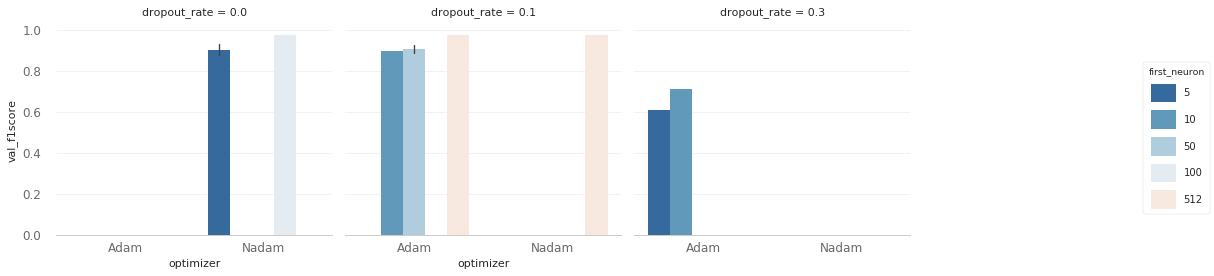

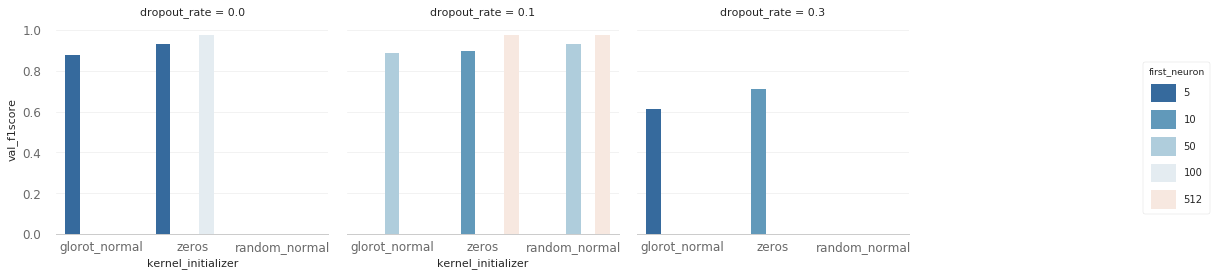

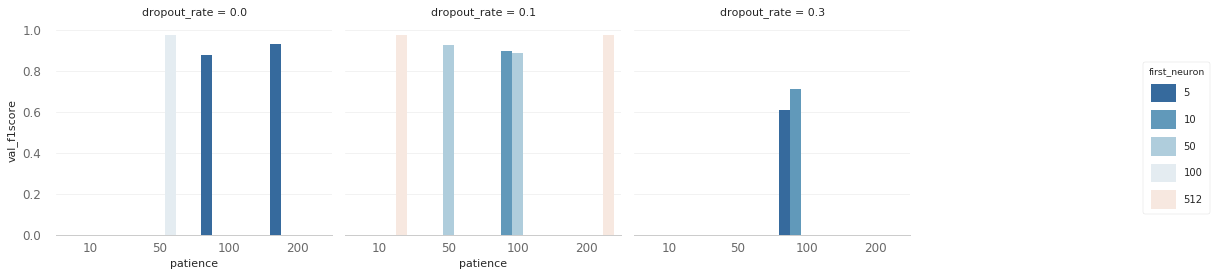

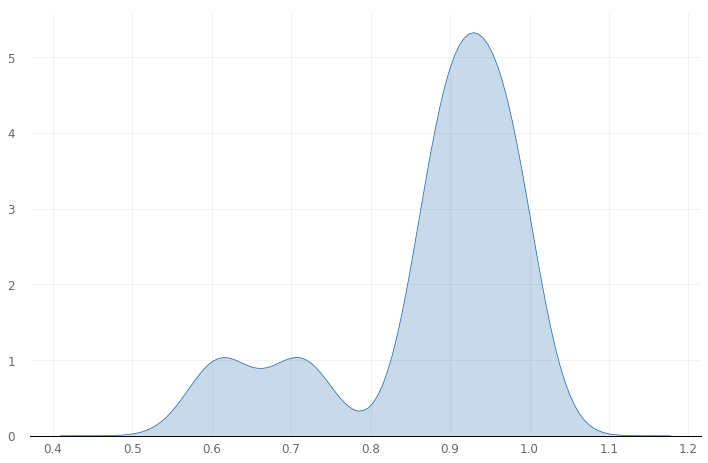

In [181]:
a.plot_bars('optimizer', 'val_f1score', 'first_neuron', 'dropout_rate')
a.plot_bars('kernel_initializer', 'val_f1score', 'first_neuron', 'dropout_rate')
a.plot_bars('patience', 'val_f1score', 'first_neuron', 'dropout_rate')
a.plot_kde(x='val_f1score')

In [184]:
bm = t.best_model(metric='val_f1score', asc=False)
print(bm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 75)                7575      
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 195)               14820     
_________________________________________________________________
dropout_3 (Dropout)          (None, 195)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 302)              

### Predict

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       900
           1       0.12      0.16      0.14        64
           2       0.26      0.21      0.23        62

    accuracy                           0.81      1026
   macro avg       0.43      0.42      0.42      1026
weighted avg       0.82      0.81      0.81      1026



<Figure size 432x288 with 0 Axes>

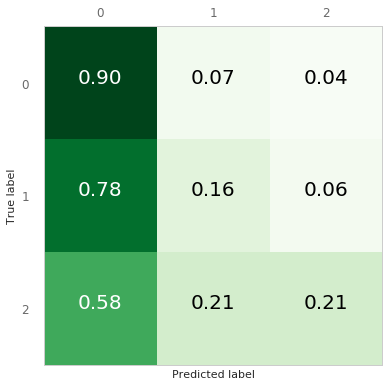

In [185]:
p = talos.Predict(t)
y_pred_proba = p.predict(X_test_random, metric='val_f1score', asc=False)
y_pred = np.argmax(y_pred_proba, axis=1)
plot_confusion_matrix(y_test_random, y_pred, range(0,3), normalize=True, cmap=plt.cm.Greens)

## Recent

In [186]:
name='loiste_jse_recent_15'
X_train_recent, y_train_recent, X_test_recent, y_test_recent = read_data('../data/{}_thin_train.csv'.format(name), 
                                                                                             '../data/{}_thin_test.csv'.format(name_random),
                                                                                             options)

X_res_recent, y_res_recent, _, _ = read_data('../data/{}_thin_res.csv'.format(name), 
                                             None,
                                             options)

Train data shape: (4923, 35)
Test data shape: (1026, 35)
Train data shape: (13545, 35)


In [188]:
params = {
        'first_neuron': 100,
        'batch_size': 556,
          'neurons': [75, None, 195, 302],
          'epochs': 500,
          'dropout_rate': .1,
          'kernel_initializer': 'zeros',
          'optimizer': 'Nadam',
          'losses': 'binary_crossentropy',
          'activation': 'relu',
          'class_weight': [0.55, 0.15, 0.3],
          'patience': 50
        }
history, model = m(X_train_recent, y_train_recent, X_test_recent, y_test_recent, params)

Epoch 00057: early stopping


              precision    recall  f1-score   support

           0       0.90      0.90      0.90       900
           1       0.12      0.16      0.14        64
           2       0.26      0.21      0.23        62

    accuracy                           0.81      1026
   macro avg       0.43      0.42      0.42      1026
weighted avg       0.82      0.81      0.81      1026



<Figure size 432x288 with 0 Axes>

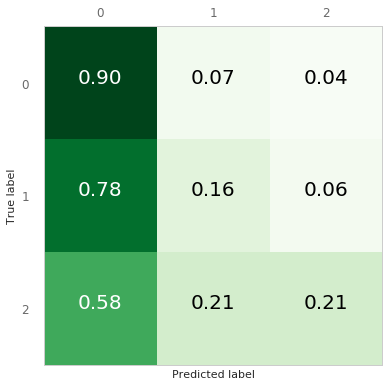

In [189]:
p = talos.Predict(t)
y_pred_proba = p.predict(X_test_random, metric='val_f1score', asc=False)
y_pred = np.argmax(y_pred_proba, axis=1)
plot_confusion_matrix(y_test_random, y_pred, range(0,3), normalize=True, cmap=plt.cm.Greens)

## Energiateollisuus

## Random

### Get data

In [7]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'thin_energiateollisuus'
read_options(options)

In [9]:
name='energiateollisuus_random_15'
X_train_random, y_train_random, X_test_random, y_test_random = read_data('../data/{}_thin_train.csv'.format(name), 
                                                                                             '../data/{}_thin_test.csv'.format(name),
                                                                                             options)

X_res_random, y_res_random, _, _ = read_data('../data/{}_thin_res.csv'.format(name), 
                                             None,
                                             options)

Train data shape: (74973, 35)
Test data shape: (18744, 35)
Train data shape: (182916, 35)


### Find setup

In [10]:
weights = []
for i in np.arange(.5, 1, .05):
    for j in np.arange(0.1, 1-i, .05):
        k = 1 - i - j 
        weights.append([i, j, k])

max_ = 512
neurons = []
for i in np.arange(5, max_, 10):
    for j in np.arange(5, max_-i, 10):
        for k in np.arange(5, max_-i-j, 10):
            l = max_ - i - j
            neurons.append([i, j, k, l])
            neurons.append([None, j, k, l])
            neurons.append([i, None, k, l])
            neurons.append([i, j, None, l])
            neurons.append([i, j, k, None])
        
param_grid = {'first_neuron':[5, 10, 50, 100, 512],
              'batch_size': [64, 128, 256, 512],
              'neurons': neurons,
              'epochs': [500],
              'dropout_rate': [0, .1, .3], #.4, .5
              'kernel_initializer': ['random_normal', 'glorot_normal', 'zeros'], #uniform
              'optimizer': ['Nadam', 'Adam'],
              'losses': ['binary_crossentropy'],
              'activation':['relu', 'elu'],
              'class_weight': weights,
              'patience': [10, 50, 100, 200]
            }

In [13]:
# Run the experiment
t = talos.Scan(x=X_res_random.values,
               y=y_res_random,
               model=m,
               params=param_grid,
               experiment_name='thin',
               round_limit=10,
               reduction_metric='val_f1score')

  0%|          | 0/10 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



 10%|█         | 1/10 [02:01<18:14, 121.62s/it]

Epoch 00036: early stopping


 20%|██        | 2/10 [04:23<17:02, 127.83s/it]

Epoch 00069: early stopping


 80%|████████  | 8/10 [31:08<07:36, 228.29s/it]

Epoch 00071: early stopping


100%|██████████| 10/10 [38:47<00:00, 232.73s/it]


In [195]:
a = talos.Analyze(t)
t.data.sort_values(by='val_f1score', ascending=False).head(2)

,round_epochs,val_loss,val_accuracy,val_f1score,loss,accuracy,f1score,activation,batch_size,class_weight,dropout_rate,epochs,first_neuron,kernel_initializer,losses,neurons,optimizer,patience
9,100,0.088406,0.980637,0.971028,0.006914,0.998253,0.997396,elu,256,"[0.7500000000000002, 0.1, 0.14999999999999977]",0.0,500,50,random_normal,binary_crossentropy,"[75, 145, 35, None]",Nadam,200
5,100,0.093015,0.979931,0.970241,0.015649,0.995161,0.992969,elu,512,"[0.6500000000000001, 0.20000000000000004, 0.14...",0.0,500,100,random_normal,binary_crossentropy,"[185, 75, 225, 252]",Adam,100


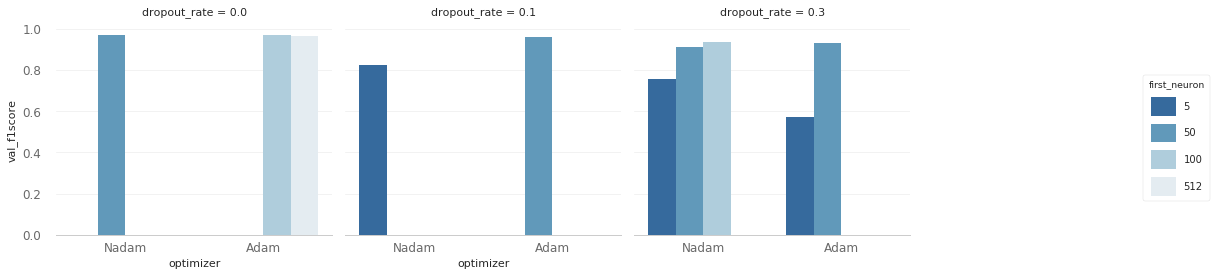

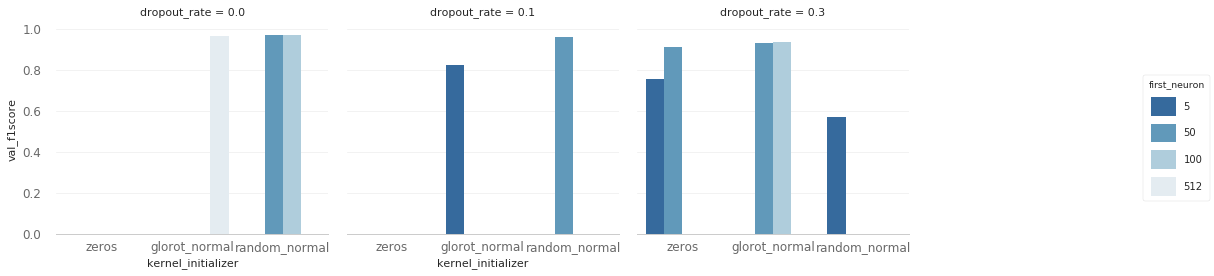

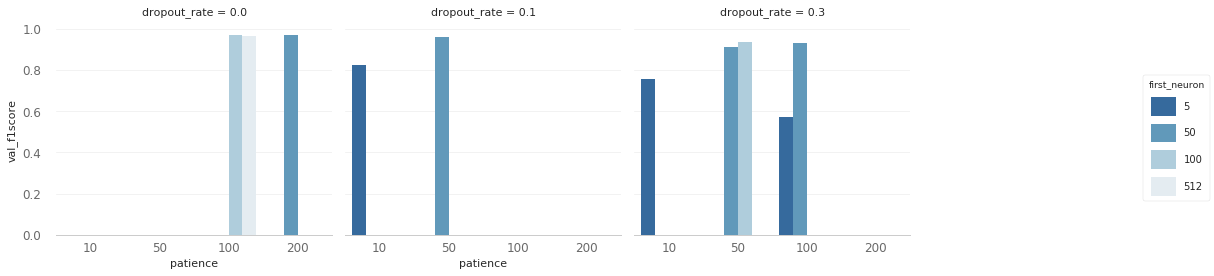

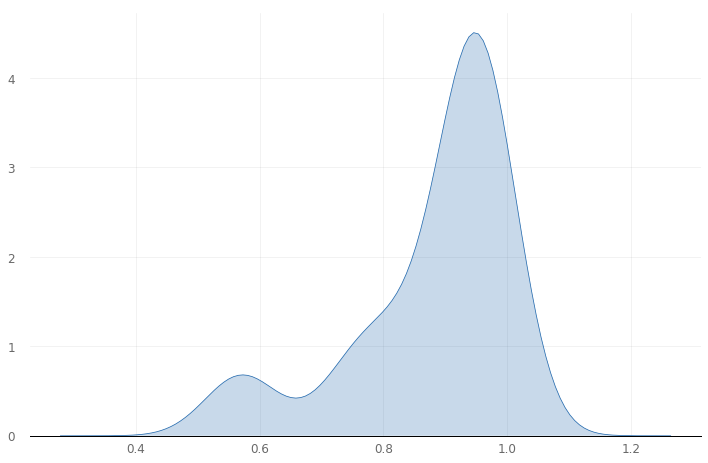

In [196]:
a.plot_bars('optimizer', 'val_f1score', 'first_neuron', 'dropout_rate')
a.plot_bars('kernel_initializer', 'val_f1score', 'first_neuron', 'dropout_rate')
a.plot_bars('patience', 'val_f1score', 'first_neuron', 'dropout_rate')
a.plot_kde(x='val_f1score')

In [14]:
bm = t.best_model(metric='val_f1score', asc=False)
print(bm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 75)                3825      
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 135)               10260     
_________________________________________________________________
dropout_3 (Dropout)          (None, 135)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 312)              

### Predict

<Figure size 432x288 with 0 Axes>

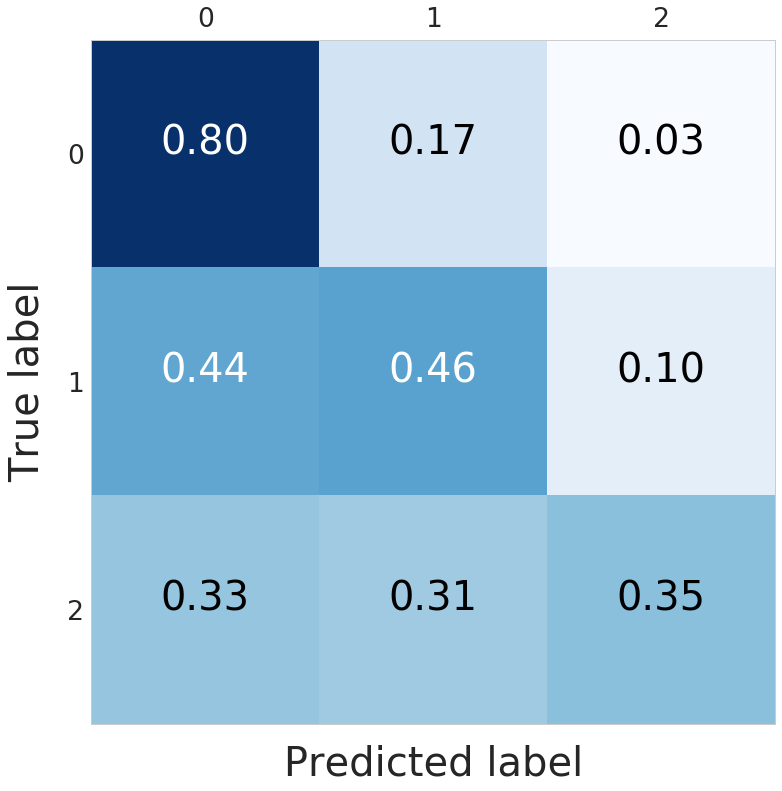

In [17]:
p = talos.Predict(t)
y_pred_proba = p.predict(X_test_random, metric='val_f1score', asc=False)
y_pred = np.argmax(y_pred_proba, axis=1)
plot_confusion_matrix(y_test_random, y_pred, range(0,3), normalize=True, cmap=plt.cm.Blues)

## Recent

In [200]:
name='energiateollisuus_recent_15'
X_train_recent, y_train_recent, X_test_recent, y_test_recent = read_data('../data/{}_thin_train.csv'.format(name), 
                                                                                             '../data/{}_thin_test.csv'.format(name),
                                                                                             options)

X_res_recent, y_res_recent, _, _ = read_data('../data/{}_thin_res.csv'.format(name), 
                                             None,
                                             options)

Train data shape: (84554, 35)
Test data shape: (9163, 35)
Train data shape: (205893, 35)


In [201]:
params = {
        'first_neuron': 200,
        'batch_size': 256,
          'neurons': [75, 145, 35, None],
          'epochs': 500,
          'dropout_rate': .0,
          'kernel_initializer': 'random_normal',
          'optimizer': 'Nadam',
          'losses': 'binary_crossentropy',
          'activation': 'relu',
          'class_weight': [0.75, 0.1, 0.15],
          'patience': 200
        }
history, model = m(X_train_recent, y_train_recent, X_test_recent, y_test_recent, params)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82     15243
           1       0.16      0.13      0.14      2884
           2       0.07      0.13      0.09       617

    accuracy                           0.69     18744
   macro avg       0.35      0.36      0.35     18744
weighted avg       0.70      0.69      0.69     18744



<Figure size 432x288 with 0 Axes>

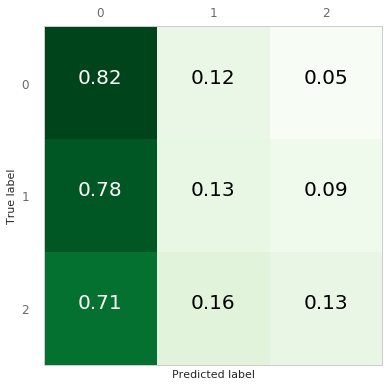

In [202]:
p = talos.Predict(t)
y_pred_proba = p.predict(X_test_random, metric='val_f1score', asc=False)
y_pred = np.argmax(y_pred_proba, axis=1)
plot_confusion_matrix(y_test_random, y_pred, range(0,3), normalize=True, cmap=plt.cm.Greens)